In [1]:
#importing pandas
%pip install pandas
import pandas as pd

#Load training dataset
train_ds = pd.read_csv("Datasets_final/train_dataset_final1.csv")

Note: you may need to restart the kernel to use updated packages.


In [2]:
#view first few rows
print(train_ds.head())

   Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0         5017         2    0          2      60000  25.0      2      2   
1         5018         2    1          1     290000  24.0      0      0   
2         5019         1    0          2     180000  63.0      0      0   
3         5020         1    1          2     210000  43.0      0      0   
4         5021         2    0          1     280000  32.0     -2     -2   

   pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0      2      0  ...   20750.63   2000.21      0.00   1134.85   1821.78   
1     -2     -2  ...    1350.30      0.00      0.17      0.00   2700.10   
2      0      0  ...   52991.51   2086.94   2199.99   1845.66   2000.35   
3      0      0  ...   76945.47   3348.07   3380.91   3400.45   2683.97   
4     -2     -2  ...       1.35    999.78   3186.27  45027.78   2100.09   

   pay_amt5  pay_amt6  AVG_Bill_amt  PAY_TO_BILL_ratio  next_month_default  
0   1500.03   1500.24

In [3]:
#check shape and null values
print("Dataset shape:",train_ds.shape)
print("\nMissing values\n",train_ds.isnull().sum())

Dataset shape: (25247, 27)

Missing values
 Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6                0
AVG_Bill_amt            0
PAY_TO_BILL_ratio       0
next_month_default      0
dtype: int64


In [4]:
# Fill missing age values with median
train_ds["age"] = train_ds["age"].fillna(train_ds["age"].median())


In [5]:
#checking for missing values again
print("\nMissing values\n",train_ds.isnull().sum())


Missing values
 Customer_ID           0
marriage              0
sex                   0
education             0
LIMIT_BAL             0
age                   0
pay_0                 0
pay_2                 0
pay_3                 0
pay_4                 0
pay_5                 0
pay_6                 0
Bill_amt1             0
Bill_amt2             0
Bill_amt3             0
Bill_amt4             0
Bill_amt5             0
Bill_amt6             0
pay_amt1              0
pay_amt2              0
pay_amt3              0
pay_amt4              0
pay_amt5              0
pay_amt6              0
AVG_Bill_amt          0
PAY_TO_BILL_ratio     0
next_month_default    0
dtype: int64


### Exploratory Data Analysis

In [6]:
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


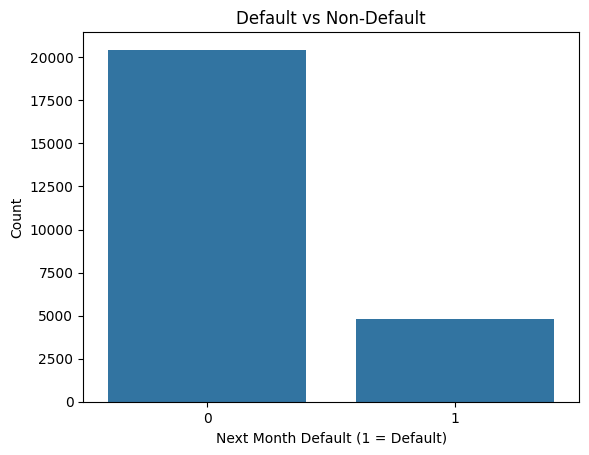

Default Rate: 19.04%


In [7]:
#checking for class imbalance
import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
sns.countplot(x='next_month_default', data=train_ds)
plt.title("Default vs Non-Default")
plt.xlabel("Next Month Default (1 = Default)")
plt.ylabel("Count")
plt.show()

# Print default rate
default_rate = train_ds['next_month_default'].mean()
print(f"Default Rate: {default_rate:.2%}")


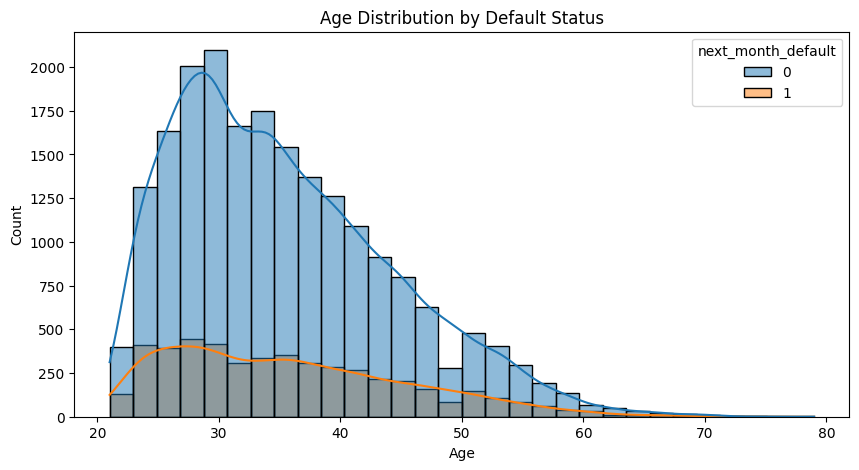

In [8]:
# Age distribution by default status
plt.figure(figsize=(10,5))
sns.histplot(data=train_ds, x='age', hue='next_month_default', bins=30, kde=True)
plt.title("Age Distribution by Default Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


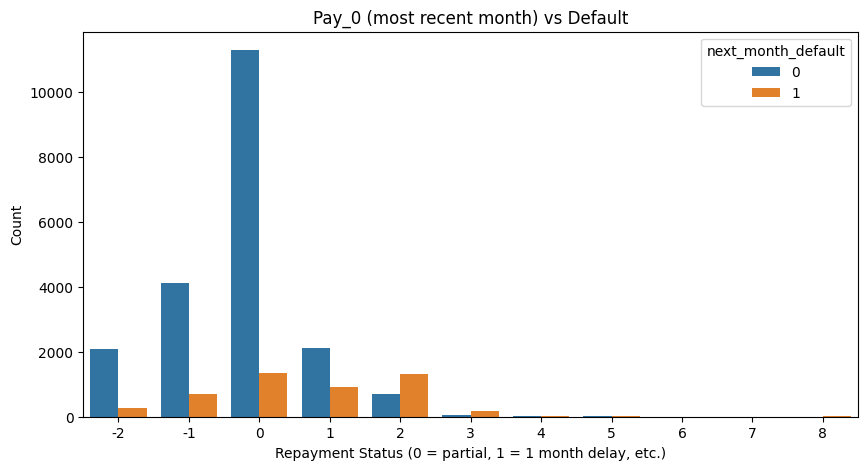

In [9]:
# Analyze one payment feature like pay_0
plt.figure(figsize=(10,5))
sns.countplot(x='pay_0', hue='next_month_default', data=train_ds)
plt.title("Pay_0 (most recent month) vs Default")
plt.xlabel("Repayment Status (0 = partial, 1 = 1 month delay, etc.)")
plt.ylabel("Count")
plt.show()


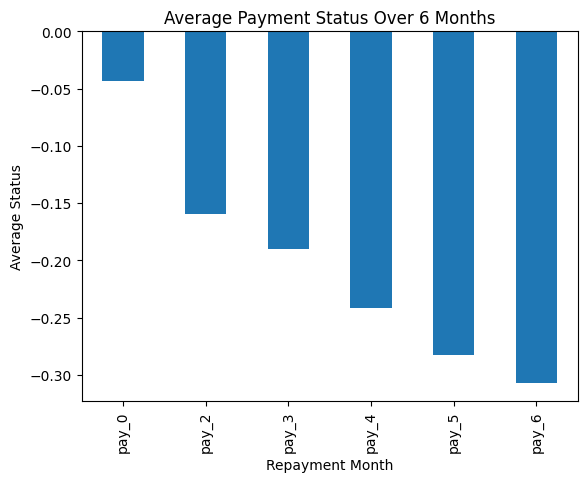

In [10]:
#trend across months

pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

train_ds[pay_cols].mean().plot(kind='bar')
plt.title("Average Payment Status Over 6 Months")

plt.xlabel("Repayment Month")
plt.ylabel("Average Status")
plt.show()


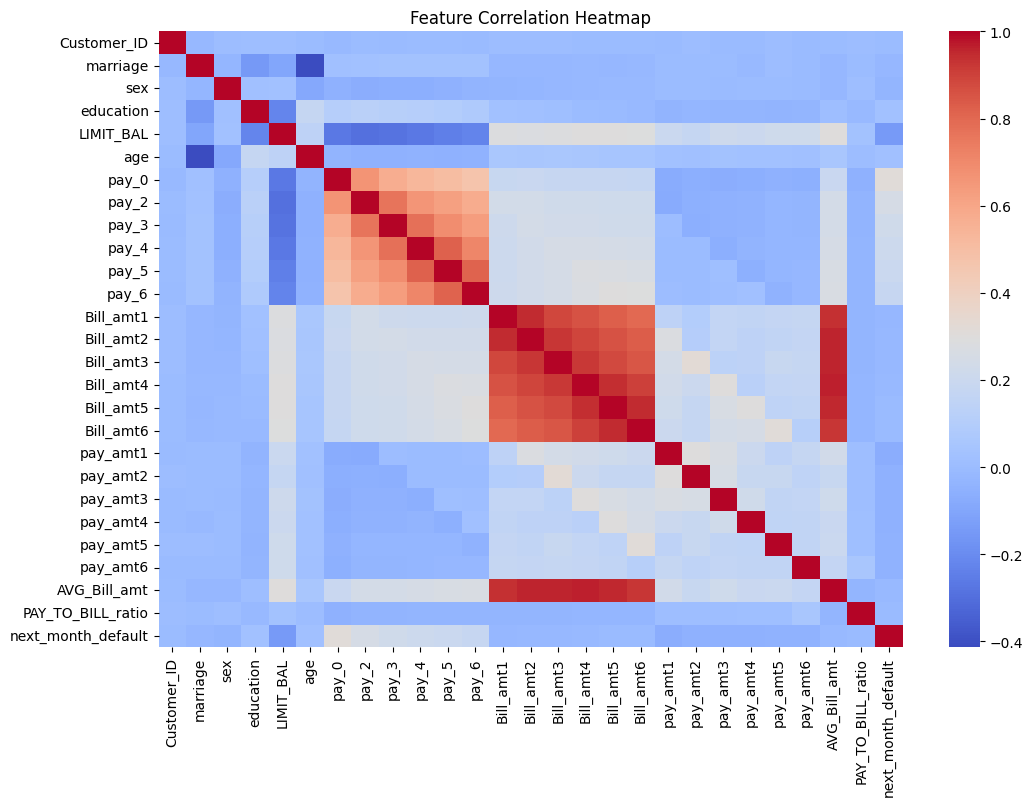

In [11]:
#correlation heatmap

plt.figure(figsize=(12,8))
sns.heatmap(train_ds.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


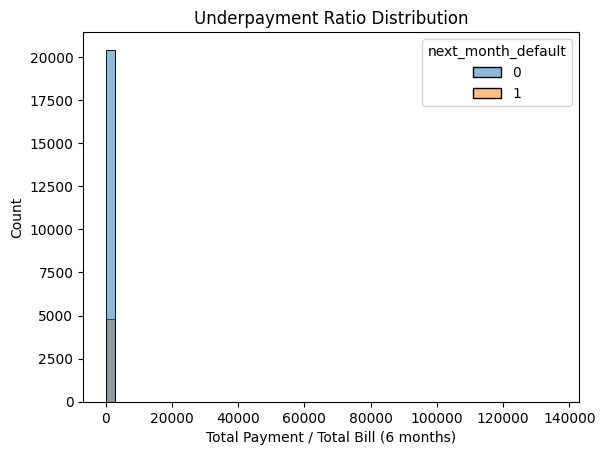

In [12]:
#bill to pay ratio across months
train_ds["bill_total"] = train_ds[[f'Bill_amt{i}' for i in range(1,7)]].sum(axis=1)
train_ds["pay_total"] = train_ds[[f'pay_amt{i}' for i in range(1,7)]].sum(axis=1)
train_ds["underpay_ratio"] = train_ds["pay_total"] / (train_ds["bill_total"] + 1)

sns.histplot(data=train_ds, x="underpay_ratio", hue="next_month_default", bins=50)
plt.title("Underpayment Ratio Distribution")
plt.xlabel("Total Payment / Total Bill (6 months)")
plt.ylabel("Count")
plt.show()


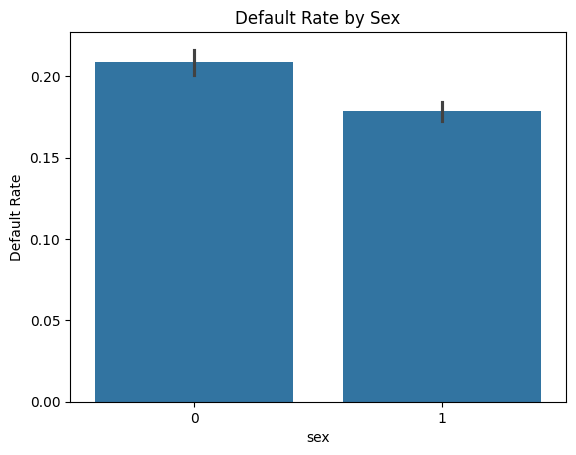

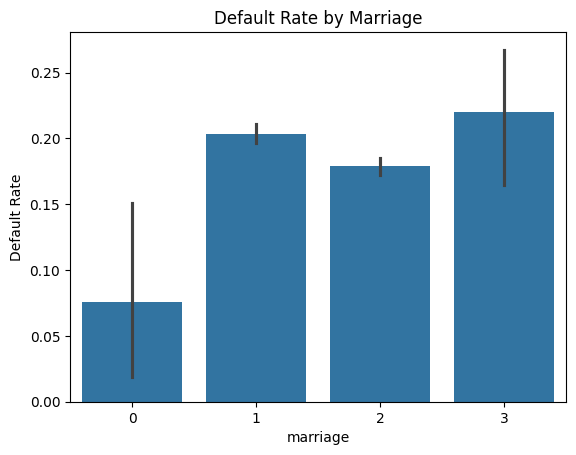

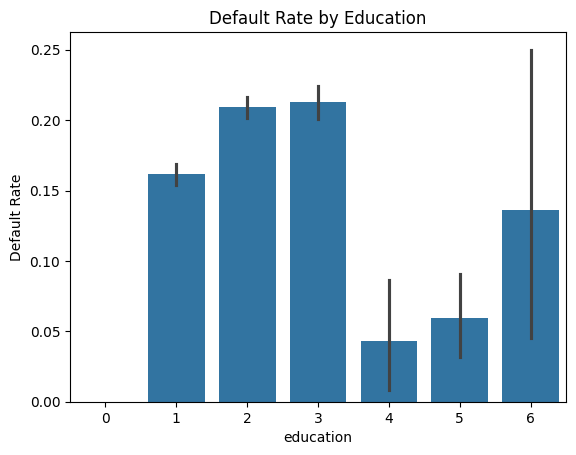

In [13]:
#comparing default rate across categorical features
for cat in ["sex", "marriage", "education"]:
    sns.barplot(x=cat, y="next_month_default", data=train_ds)
    plt.title(f"Default Rate by {cat.capitalize()}")
    plt.ylabel("Default Rate")
    plt.show()


### Feature Engineering

In [14]:
# 1. Average delay status
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
train_ds['avg_delay'] = train_ds[pay_cols].mean(axis=1)

# 2. Count of months with delay
train_ds['delay_count'] = (train_ds[pay_cols] > 0).sum(axis=1)

# 3. Trend in payment (recent - old)
train_ds['improvement'] = train_ds['pay_0'] - train_ds['pay_6']

# 4. Credit utilization
train_ds['util_ratio'] = train_ds['AVG_Bill_amt'] / (train_ds['LIMIT_BAL'] + 1)

# 5. Maximum delay
train_ds['max_delay'] = train_ds[pay_cols].max(axis=1)


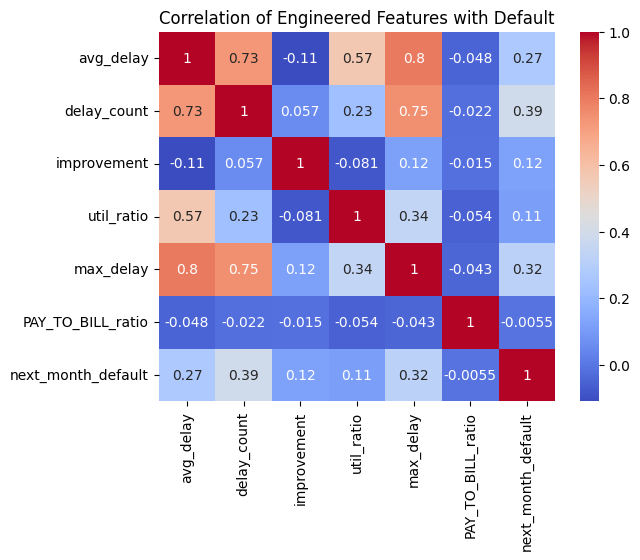

In [15]:
corr_features = ['avg_delay', 'delay_count', 'improvement', 'util_ratio', 'max_delay', 'PAY_TO_BILL_ratio', 'next_month_default']
sns.heatmap(train_ds[corr_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Engineered Features with Default")
plt.show()


### Correlation Insights with next_month_default
Feature	Correlation	Interpretation


| Feature             | Correlation | Interpretation                                             |
| ------------------- | ----------- | ---------------------------------------------------------- |
| `delay_count`       | **0.39**    | 🔥 Strongest predictor — more late months → higher default |
| `max_delay`         | 0.32        | High max delay = risky                                     |
| `avg_delay`         | 0.27        | Average delay over months matters                          |
| `improvement`       | 0.12        | Positive (getting worse) has some effect                   |
| `util_ratio`        | 0.11        | Credit utilization has small impact                        |
| `PAY_TO_BILL_ratio` | -0.0055     | Almost no correlation — not predictive here                |


Delay-based features such as count and severity of payment delays strongly correlate with future default. This aligns with credit theory where repayment history is a primary risk indicator.

In [16]:
# Install imbalanced-learn (for SMOTE)
%pip install -q imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [17]:
# 📦 Imports
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Define features and target
X = train_ds.drop(columns=['Customer_ID', 'next_month_default'])
y = train_ds['next_month_default']

#  Standardize numeric features (recommended for LogReg)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#  Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# ⚖️ Apply SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

#  Show distribution before and after SMOTE
print("Original class distribution:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_smote).value_counts())


Original class distribution:
 next_month_default
0    16352
1     3845
Name: count, dtype: int64

After SMOTE:
 next_month_default
0    16352
1    16352
Name: count, dtype: int64


In [18]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Helper to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    f2 = fbeta_score(y_test, y_pred, beta=2)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"F2 Score     : {f2:.4f}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"AUC-ROC      : {auc:.4f}")
    return f2

# 📘 Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

print("\n🔍 Logistic Regression Performance:")
f2_logreg = evaluate_model(logreg, X_test, y_test)




🔍 Logistic Regression Performance:
F2 Score     : 0.5649
Accuracy     : 0.7630
Precision    : 0.4177
Recall       : 0.6195
AUC-ROC      : 0.7661


In [20]:
import numpy as np
from sklearn.metrics import fbeta_score

y_probs = logreg.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.05)

best_f2, best_thresh = 0, 0.5

for t in thresholds:
    preds = (y_probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    print(f"Threshold {t:.2f} → F2 Score: {f2:.4f}")
    if f2 > best_f2:
        best_f2, best_thresh = f2, t

print(f"\n✅ Best Threshold: {best_thresh:.2f} with F2 Score: {best_f2:.4f}")



Threshold 0.10 → F2 Score: 0.5426
Threshold 0.15 → F2 Score: 0.5466
Threshold 0.20 → F2 Score: 0.5544
Threshold 0.25 → F2 Score: 0.5651
Threshold 0.30 → F2 Score: 0.5791
Threshold 0.35 → F2 Score: 0.5919
Threshold 0.40 → F2 Score: 0.5868
Threshold 0.45 → F2 Score: 0.5816
Threshold 0.50 → F2 Score: 0.5649
Threshold 0.55 → F2 Score: 0.5535
Threshold 0.60 → F2 Score: 0.5277
Threshold 0.65 → F2 Score: 0.5005
Threshold 0.70 → F2 Score: 0.4546
Threshold 0.75 → F2 Score: 0.3860
Threshold 0.80 → F2 Score: 0.3061
Threshold 0.85 → F2 Score: 0.2336

✅ Best Threshold: 0.35 with F2 Score: 0.5919


In [21]:
# Train XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)

print("\n🔍 XGBoost Performance:")
f2_xgb = evaluate_model(xgb, X_test, y_test)

/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:20:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 XGBoost Performance:
F2 Score     : 0.4109
Accuracy     : 0.8246
Precision    : 0.5571
Recall       : 0.3857
AUC-ROC      : 0.7539


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
rf.fit(X_train_smote, y_train_smote)

print("\n🌲 Random Forest Performance:")
f2_rf = evaluate_model(rf, X_test, y_test)



🌲 Random Forest Performance:
F2 Score     : 0.5271
Accuracy     : 0.7947
Precision    : 0.4666
Recall       : 0.5447
AUC-ROC      : 0.7773


In [23]:
%pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [24]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42, n_estimators=150, max_depth=10)
lgb.fit(X_train_smote, y_train_smote)

print("\n💡 LightGBM Performance:")
f2_lgb = evaluate_model(lgb, X_test, y_test)


[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8257
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

💡 LightGBM Performance:
F2 Score     : 0.4377
Accuracy     : 0.8382
Precision    : 0.6131
Recall       : 0.4085
AUC-ROC      : 0.7688


In [25]:
# the again featuer engineering

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

# Drop target and ID
X = train_ds.drop(columns=['Customer_ID', 'next_month_default'])
y = train_ds['next_month_default']

# Standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Select top 20 features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names (optional for plotting)
selected_columns = X.columns[selector.get_support()]
print("Selected Features:\n", selected_columns.tolist())


Selected Features:
 ['sex', 'LIMIT_BAL', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'pay_total', 'avg_delay', 'delay_count', 'improvement', 'util_ratio', 'max_delay']


In [27]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)


In [28]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

print("\n🎯 Logistic Regression with Top 20 Features:")
evaluate_model(logreg, X_test, y_test)



🎯 Logistic Regression with Top 20 Features:
F2 Score     : 0.5646
Accuracy     : 0.7624
Precision    : 0.4168
Recall       : 0.6195
AUC-ROC      : 0.7646


0.5646078059871164

In [29]:
xgb1 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb1.fit(X_train_smote, y_train_smote)

print("\n🔍 XGBoost Performance:")
f2_xgb1 = evaluate_model(xgb1, X_test, y_test)

/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:20:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 XGBoost Performance:
F2 Score     : 0.4517
Accuracy     : 0.8010
Precision    : 0.4761
Recall       : 0.4459
AUC-ROC      : 0.7465


In [30]:
lgb2 = LGBMClassifier(random_state=42, n_estimators=150, max_depth=10)
lgb2.fit(X_train_smote, y_train_smote)

print("\n💡 LightGBM Performance:")
f2_lgb2 = evaluate_model(lgb2, X_test, y_test)

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4740
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

💡 LightGBM Performance:
F2 Score     : 0.4688
Accuracy     : 0.8267
Precision    : 0.5557
Recall       : 0.4511
AUC-ROC      : 0.7657


/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [31]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('rf', rf),
        ('xgb', xgb),
        ('lgb', lgb)
    ],
    voting='soft'  # use predicted probabilities
)

ensemble.fit(X_train_smote, y_train_smote)


/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:20:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4740
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


VotingClassifier(estimators=[('logreg', LogisticRegression(max_iter=1000)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=150,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eva...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgb',
                              LGBMClassifier(max_depth=10, n_estimators=150,
                                             random_state=42))],
                 voting='soft')

In [32]:
print("\n🤝 Ensemble (VotingClassifier) Performance:")
evaluate_model(ensemble, X_test, y_test)



🤝 Ensemble (VotingClassifier) Performance:


/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F2 Score     : 0.5116
Accuracy     : 0.8143
Precision    : 0.5125
Recall       : 0.5114
AUC-ROC      : 0.7816


0.5116472545757071

In [33]:
probs = ensemble.predict_proba(X_test)[:, 1]

best_f2, best_thresh = 0, 0.5
for t in np.arange(0.1, 0.9, 0.05):
    preds = (probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    print(f"Threshold {t:.2f} → F2 Score: {f2:.4f}")
    if f2 > best_f2:
        best_f2, best_thresh = f2, t

print(f"\n✅ Best Threshold: {best_thresh:.2f} with F2 Score: {best_f2:.4f}")


Threshold 0.10 → F2 Score: 0.5473
Threshold 0.15 → F2 Score: 0.5674
Threshold 0.20 → F2 Score: 0.5943
Threshold 0.25 → F2 Score: 0.6033
Threshold 0.30 → F2 Score: 0.6028
Threshold 0.35 → F2 Score: 0.5900
Threshold 0.40 → F2 Score: 0.5805
Threshold 0.45 → F2 Score: 0.5416
Threshold 0.50 → F2 Score: 0.5116
Threshold 0.55 → F2 Score: 0.4846
Threshold 0.60 → F2 Score: 0.4496
Threshold 0.65 → F2 Score: 0.4060
Threshold 0.70 → F2 Score: 0.3666
Threshold 0.75 → F2 Score: 0.2900
Threshold 0.80 → F2 Score: 0.2078
Threshold 0.85 → F2 Score: 0.1318

✅ Best Threshold: 0.25 with F2 Score: 0.6033


/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base learners
base_learners = [
    ('logreg', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Meta learner (on top of base learners)
meta_learner = LogisticRegression()

# Build Stacking model
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5
)

# Train the model
stack_model.fit(X_train_smote, y_train_smote)


/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:21:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:22:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:22:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


StackingClassifier(cv=5,
                   estimators=[('logreg', LogisticRegression(max_iter=1000)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=Fa...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression())

In [35]:
print("\n🧱 Stacking Classifier Performance:")
evaluate_model(stack_model, X_test, y_test)



🧱 Stacking Classifier Performance:
F2 Score     : 0.4828
Accuracy     : 0.7905
Precision    : 0.4538
Recall       : 0.4906
AUC-ROC      : 0.7546


0.4828150572831424

In [36]:
probs = stack_model.predict_proba(X_test)[:, 1]
best_f2, best_thresh = 0, 0.5

for t in np.arange(0.1, 0.9, 0.05):
    preds = (probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    print(f"Threshold {t:.2f} → F2 Score: {f2:.4f}")
    if f2 > best_f2:
        best_f2, best_thresh = f2, t

print(f"\n✅ Best Threshold: {best_thresh:.2f} with F2 Score: {best_f2:.4f}")


Threshold 0.10 → F2 Score: 0.5774
Threshold 0.15 → F2 Score: 0.5865
Threshold 0.20 → F2 Score: 0.5755
Threshold 0.25 → F2 Score: 0.5657
Threshold 0.30 → F2 Score: 0.5539
Threshold 0.35 → F2 Score: 0.5361
Threshold 0.40 → F2 Score: 0.5243
Threshold 0.45 → F2 Score: 0.5095
Threshold 0.50 → F2 Score: 0.4828
Threshold 0.55 → F2 Score: 0.4589
Threshold 0.60 → F2 Score: 0.4394
Threshold 0.65 → F2 Score: 0.4168
Threshold 0.70 → F2 Score: 0.3941
Threshold 0.75 → F2 Score: 0.3626
Threshold 0.80 → F2 Score: 0.3249
Threshold 0.85 → F2 Score: 0.2796

✅ Best Threshold: 0.15 with F2 Score: 0.5865


In [45]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif


ENROLL = "22112075" 

val_df = pd.read_csv("Datasets_final/validate_dataset_final.csv")

pay_cols     = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
bill_cols    = [f"Bill_amt{i}" for i in range(1,7)]
pay_amt_cols = [f"pay_amt{i}"  for i in range(1,7)]

val_df["bill_total"]     = val_df[bill_cols].sum(axis=1)
val_df["pay_total"]      = val_df[pay_amt_cols].sum(axis=1)
val_df["underpay_ratio"] = val_df["pay_total"] / (val_df["bill_total"] + 1)

val_df["avg_delay"]    = val_df[pay_cols].mean(axis=1)
val_df["delay_count"]  = (val_df[pay_cols] > 0).sum(axis=1)
val_df["improvement"]  = val_df["pay_0"] - val_df["pay_6"]
val_df["util_ratio"]   = val_df["AVG_Bill_amt"] / (val_df["LIMIT_BAL"] + 1)
val_df["max_delay"]    = val_df[pay_cols].max(axis=1)

full_features = train_ds.drop(columns=["Customer_ID","next_month_default"]).columns.tolist()
X_val_full    = val_df[full_features]

X_val_scaled_full = pd.DataFrame(
    scaler.transform(X_val_full),
    columns=full_features
)

try:
    sel_cols = selected_columns
except NameError:
    X_train_scaled = pd.DataFrame(
        scaler.transform(train_ds[full_features]),
        columns=full_features
    )
    selector = SelectKBest(score_func=f_classif, k=20).fit(
        X_train_scaled, train_ds["next_month_default"]
    )
    sel_cols = X_train_scaled.columns[selector.get_support()].tolist()

X_val_selected = X_val_scaled_full[sel_cols]

probs = stack_model.predict_proba(X_val_selected)[:, 1]
preds = (probs >= 0.25).astype(int)

submission = pd.DataFrame({
    "Customer_ID":        val_df["Customer_ID"],
    "next_month_default": preds
})
filename = f"submission_{ENROLL}.csv"
submission.to_csv(filename, index=False)
print(f"✅ {filename} created with {len(submission)} rows")


✅ submission_22112075.csv created with 5016 rows


/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/xoion/CreditCardProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
